In [36]:
# %reset -f

import sys
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, median_absolute_error

# install custom package with: pip install git+https://github.com/owenodriscoll/AutoML.git
sys.path.insert(0, os.path.abspath('..'))  # hacky way to import within package
from AutoML import AutomatedRegression
from importlib import reload
import AutoML; reload(AutoML); from AutoML.misc import outlier_detector, plot_envelope_single
# from AutoML.misc import outlier_detector, plot_envelope_single

In [37]:
#%% load data

data_dir = '/Users/opodriscoll/Documents/Data/'
df_rolls = pd.read_csv(f'{data_dir}df_rolls.csv')
df_cells = pd.read_csv(f'{data_dir}df_cells.csv')

df = pd.concat([df_cells, df_rolls]) 

In [38]:
#%% filtering of estimates 

# -- conditions for filtering
window_effect_threshhold_low = 0.5
window_effect_threshhold_high = 1.5
S_windfield_xi_norm_std_threshhold = 0.25
inertial_subrange_length_fraction_threshold = 0.2 
inertial_subrange_length_threshold = 200 # m
peak_max_threshold = 2950
peak_min_threshold = 610
min_heatflux = 0 # (into atmos)
max_obukhov = 0

# -- filtering
df_val = df.loc[(df['L_era5'] < max_obukhov) & (df['hsb_era5'] > min_heatflux) & (df['hlb_era5'] > min_heatflux)]
df_val = df_val[(df_val.window_effect >= window_effect_threshhold_low) & (df_val.window_effect <= window_effect_threshhold_high)]
df_val = df_val[df_val.S_windfield_xi_norm_std <= S_windfield_xi_norm_std_threshhold]
df_val = df_val[(df_val.spectral_peak - df_val.spectral_valley)/df_val.spectral_peak >= inertial_subrange_length_fraction_threshold]
df_val = df_val[((df_val.spectral_peak - df_val.spectral_valley) >= inertial_subrange_length_threshold)]
df_val = df_val[(df_val.spectral_peak< peak_max_threshold) & (df_val.spectral_peak > peak_min_threshold)]

# -- outlier removal between parameters 'window_effect' and 'S_windfield_xi_norm_std'
df_val = outlier_detector(df_val, 'window_effect', 'S_sigma0_xi_norm_std', pca_comp=0.80, neighbours = 100, plot_PCA=False)    # S_normalised_deviation, sign_wind2
df_val = df_val.reset_index(drop = True)  

# -- select observation data only
keep_after_index = list(df_val.keys()).index('U_n') # U_n is first observation column
keep_before_index = list(df_val.keys()).index('energy_dir_range') +1 # S_windfield_xi_norm_std is the last measured param 
df_obs = df_val.iloc[:,keep_after_index:keep_before_index] 

# -- replace original estimate of Obukhov length by the a logarithmic version 
df_obs['L'] = np.log10(abs(df_obs['L']))

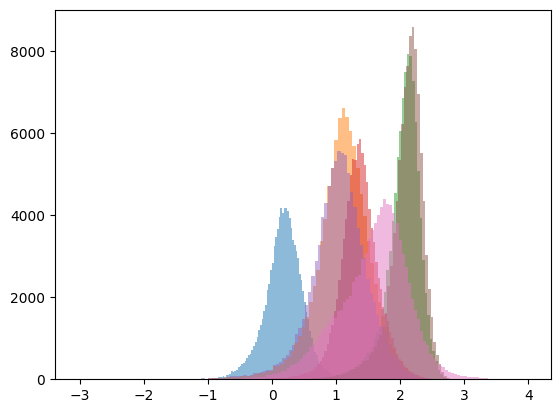

In [39]:
#%% Select data, split into X and y- matrix and exclude scenes for analysis later on

# -- observation
X_sar = df_obs.drop(columns = ['S_sigma0_xi_norm_std', 'S_sigma0_xi_mean', 'wdir'])
X_scat = df_obs[['U_n', 'incidence_avg', 'energy_dir_range']] 

# -- validation
y_deltaT_log = np.log10(abs(df_val.tsea_era5-df_val.tair_era5))
y_hlb_log = np.log10(df_val['hsb_era5']) # FIXME this should be hsb
y_hsb_log = np.log10(df_val.hlb_era5) # FIXME this should be hlb
y_hbb_log = np.log10(abs(df_val.hbb_era5))
y_sshf_log = np.log10(abs(df_val['sshf_era5']))
y_slhf_log = np.log10(abs(df_val['slhf_era5']))
y_L_log = np.log10(abs(df_val['L_era5']))

plt.hist(y_deltaT_log, bins = 100, alpha = 0.5);
plt.hist(y_hlb_log, bins = 100, alpha = 0.5)
plt.hist(y_hsb_log, bins = 100, alpha = 0.5)
plt.hist(y_hbb_log, bins = 100, alpha = 0.5)
plt.hist(y_sshf_log, bins = 100, alpha = 0.5)
plt.hist(y_slhf_log, bins = 100, alpha = 0.5)
_ = plt.hist(y_L_log, bins = 100, alpha = 0.5)

In [40]:
#%% Prepare Machine Learning 
n_trials = 0

result_deltaT_log = AutomatedRegression(
    y = y_deltaT_log, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_deltaT_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_hlb_log = AutomatedRegression(
    y = y_hlb_log, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_hlb_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_hsb_log = AutomatedRegression(
    y = y_hsb_log, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_hsb_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_hbb_log = AutomatedRegression(
    y = y_hbb_log, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_hbb_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_sshf_log = AutomatedRegression(
    y = y_sshf_log, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_sshf_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_slhf_log = AutomatedRegression(
    y = y_slhf_log, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_slhf_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_L_log = AutomatedRegression(
    y = y_L_log, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_L_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

In [41]:
#%% Apply the regression
result_deltaT_log.apply()
result_hlb_log.apply()
result_hsb_log.apply()
result_hbb_log.apply()
result_slhf_log.apply()
result_sshf_log.apply()
result_L_log.apply()

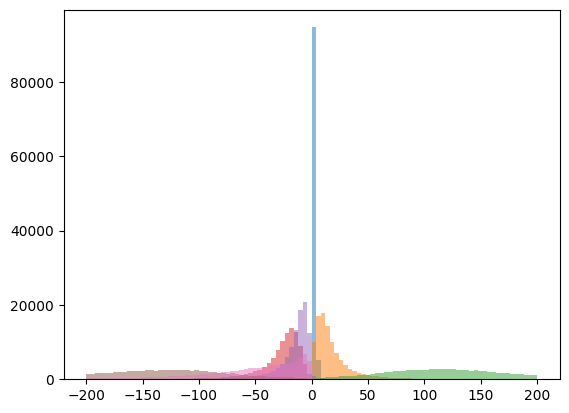

In [42]:
# -- validation
y_deltaT = df_val.tsea_era5-df_val.tair_era5
y_hlb = df_val['hsb_era5'] # FIXME this should be hsb
y_hsb = df_val.hlb_era5 # FIXME this should be hlb
y_hbb = df_val.hbb_era5
y_sshf = df_val['sshf_era5']
y_slhf = df_val['slhf_era5']
y_L = df_val['L_era5']

plt.hist(y_deltaT, bins = 100, alpha = 0.5, range = (-200, 200));
plt.hist(y_hlb, bins = 100, alpha = 0.5, range = (-200, 200))
plt.hist(y_hsb, bins = 100, alpha = 0.5, range = (-200, 200))
plt.hist(y_hbb, bins = 100, alpha = 0.5, range = (-200, 200))
plt.hist(y_sshf, bins = 100, alpha = 0.5, range = (-200, 200))
plt.hist(y_slhf, bins = 100, alpha = 0.5, range = (-200, 200))
_ = plt.hist(y_L, bins = 100, alpha = 0.5, range = (-200, 200))

In [43]:
#%% Prepare Machine Learning 
n_trials = 0

result_deltaT = AutomatedRegression(
    y = y_deltaT, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_deltaT_nonlog_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_hlb = AutomatedRegression(
    y = y_hlb, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_hlb_nonlog_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_hsb = AutomatedRegression(
    y = y_hsb, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_hsb_nonlog_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_hbb = AutomatedRegression(
    y = y_hbb, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_hbb_nonlog_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_sshf = AutomatedRegression(
    y = y_sshf, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_sshf_nonlog_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_slhf = AutomatedRegression(
    y = y_slhf, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_slhf_nonlog_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_L = AutomatedRegression(
    y = y_L, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_L_nonlog_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

In [45]:
#%% Apply the regression
result_deltaT.apply()
# result_hlb.apply()
result_hsb.apply()
# result_hbb.apply()
# result_slhf.apply()
# result_sshf.apply()
result_L.apply()

[I 2023-10-04 09:36:53,292] Using an existing study with name 'regression_lightgbm' instead of creating a new one.
[I 2023-10-04 09:36:53,343] Using an existing study with name 'regression_lightgbm' instead of creating a new one.
[I 2023-10-04 09:38:05,611] Using an existing study with name 'regression_lightgbm' instead of creating a new one.
[I 2023-10-04 09:38:05,635] Using an existing study with name 'regression_lightgbm' instead of creating a new one.


_________________________
Stacked model overwritten
_________________________



[I 2023-10-04 09:38:30,855] Using an existing study with name 'regression_lightgbm' instead of creating a new one.
[I 2023-10-04 09:38:30,883] Using an existing study with name 'regression_lightgbm' instead of creating a new one.


_________________________
Stacked model overwritten
_________________________

_________________________
Stacked model overwritten
_________________________



In [24]:
def r2(x):
    return x.summary['lightgbm_best'][1][0]

def r2_power(x):
    return r2_score(10**x.y_test, 10**x.y_pred)

def r2_log(x):
    return r2_score(np.log10(abs(x.y_test)), np.log10(abs(x.y_pred)))

In [26]:
to_log = [r2(result_deltaT_log), r2(result_hlb_log), r2(result_hsb_log), r2(result_hbb_log), r2(result_slhf_log), r2(result_sshf_log), r2(result_L_log)]
to_log_unlog = [r2_power(result_deltaT_log), r2_power(result_hlb_log), r2_power(result_hsb_log), r2_power(result_hbb_log), r2_power(result_slhf_log), r2_power(result_sshf_log), r2_power(result_L_log)]
to_non = [r2(result_deltaT), r2(result_hlb), r2(result_hsb), r2(result_hbb), r2(result_slhf), r2(result_sshf), r2(result_L)]
to_non_power = [r2_log(result_deltaT), r2_log(result_hlb), r2_log(result_hsb), r2_log(result_hbb), r2_log(result_slhf), r2_log(result_sshf), r2_log(result_L)]

pd.DataFrame(
    data = np.array([to_log, to_log_unlog, to_non, to_non_power]).T, 
    columns = ["log", "log_inv_log", "none", "none_power"], 
    index=["delta_T", "shf_coare", "lhf_coare", "buoyancy_coare", "lhf_era5", "shf_era5", "L_coare"]
    )

,log,log_inv_log,none,none_power
delta_T,0.530402,0.602831,0.630629,0.498512
shf_coare,0.521171,0.692333,0.722461,0.435776
lhf_coare,0.794482,0.775273,0.770995,0.709109
buoyancy_coare,0.627293,0.728332,0.734762,0.567194
lhf_era5,0.775397,0.761553,0.760564,0.678761
shf_era5,0.544435,0.725037,0.752759,0.497901
L_coare,0.782871,0.316267,0.381021,0.700422


Text(0.5, 1.0, 'DeltaT')

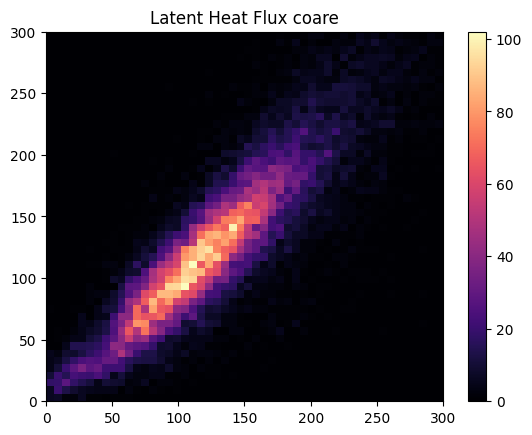

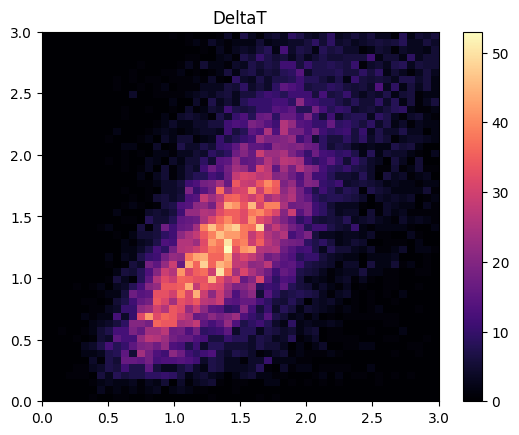

In [55]:
plt.figure(); plt.hist2d(np.ravel(result_hsb.y_pred), np.ravel(result_hsb.y_test), bins=(50, 50), cmap="magma", range = [(0, 300), (0,300)]); plt.colorbar(); plt.title("Latent Heat Flux coare")
plt.figure(); plt.hist2d(np.ravel(result_deltaT.y_pred), np.ravel(result_deltaT.y_test), bins=(50, 50), cmap="magma", range = [(0.0, 3), (0.0, 3)]); plt.colorbar(); plt.title("DeltaT")

In [13]:
n_trial = 0 # 200 for original?

result_deltaT_2 = AutomatedRegression(
    y = y_deltaT, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 2400,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trial,   # currently allowed a max of 20 trials, for study set to 200
    n_jobs = 1, 
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_deltaT_nonlog_v1",
    models_to_optimize = ['lightgbm', 'catboost', 'xgboost', 'bayesianridge', 'lassolars'],
    random_state = 42)

In [14]:
result_deltaT_2.apply()

[I 2023-10-03 20:09:19,603] Using an existing study with name 'regression_lightgbm' instead of creating a new one.
[I 2023-10-03 20:09:19,668] Using an existing study with name 'regression_catboost' instead of creating a new one.
[I 2023-10-03 20:09:19,812] Using an existing study with name 'regression_xgboost' instead of creating a new one.
[I 2023-10-03 20:09:19,849] Using an existing study with name 'regression_bayesianridge' instead of creating a new one.
[I 2023-10-03 20:09:19,919] Using an existing study with name 'regression_lassolars' instead of creating a new one.
[I 2023-10-03 20:09:20,046] Using an existing study with name 'regression_lightgbm' instead of creating a new one.
[I 2023-10-03 20:09:20,115] Using an existing study with name 'regression_catboost' instead of creating a new one.
[I 2023-10-03 20:09:20,200] Using an existing study with name 'regression_xgboost' instead of creating a new one.
[I 2023-10-03 20:09:20,249] Using an existing study with name 'regression_ba

_________________________
Stacked model overwritten
_________________________



In [15]:
result_deltaT_2.summary

{'lightgbm_best': [[0.587152122263116, 0.014509235247686889],
  [0.6342294168629186, 0.010772520303795878],
  [0.6343019487026724, 0.010817701705929373],
  [0.37884963209516154, 0.0060659643072318815]],
 'catboost_best': [[0.6039515706746654, 0.018131284225213908],
  [0.6238952554039253, 0.008028220183503385],
  [0.6239900981742121, 0.008081476764082107],
  [0.38749570630860214, 0.008021345077649454]],
 'xgboost_best': [[0.5965709676455295, 0.02008282405858089],
  [0.6285012325150212, 0.009222605684382485],
  [0.6285835201366886, 0.009262254042024751],
  [0.38548057299293514, 0.009902665110185973]],
 'bayesianridge_best': [[0.889790410663364, 0.0293009695050058],
  [0.44595363621201944, 0.011136144949616275],
  [0.44617834508020693, 0.011202436030301402],
  [0.4810841601497877, 0.009781367398761644]],
 'lassolars_best': [[0.8897758016369075, 0.02931261480074141],
  [0.44596295925262347, 0.011136705467935784],
  [0.44618760144886915, 0.011202536526193666],
  [0.48097804330609195, 0.0099

Text(0.5, 1.0, 'DeltaT')

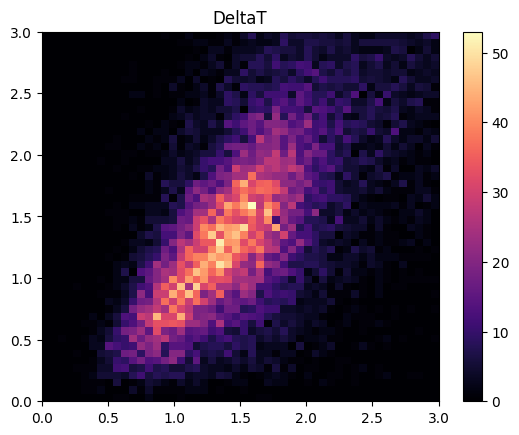

In [19]:
plt.figure(); plt.hist2d(np.ravel(result_deltaT_2.y_pred), np.ravel(result_deltaT_2.y_test), bins=(50, 50), cmap="magma", range = [(0.0, 3), (0.0, 3)]); plt.colorbar(); plt.title("DeltaT")

In [22]:
n_trial = 0 # 100 for original

result_deltaT_3 = AutomatedRegression(
    y = y_deltaT, 
    X = X_scat, 
    test_frac = 0.2, 
    timeout = 1800,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trial,   # currently allowed a max of 20 trials, for study set to 200
    n_jobs = 6, 
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_deltaT_nonlog_v2",
    models_to_optimize = ['lightgbm', 'lassolars'],
    random_state = 42)

In [23]:
result_deltaT_3.apply()

[I 2023-10-03 20:19:48,644] A new study created in RDB with name: regression_lightgbm


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=1.06675180375615, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.06675180375615
[LightGBM] [Warning] feature_fraction is set=0.2946043389981073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2946043389981073
[LightGBM] [Warning] bagging_fraction is set=0.19705921427045975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19705921427045975
[LightGBM] [Warning] lambda_l2 is set=0.021146226696964344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021146226696964344
[LightGBM] [Warning] lambda_l1 is set=6.163860706460662e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.163860706460662e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=6.165705

[I 2023-10-03 20:19:54,689] Trial 0 finished with value: 0.19070733040776594 and parameters: {'scaler': None, 'objective': 'regression', 'max_depth': 10, 'n_estimators': 59, 'max_bin': 63, 'min_gain_to_split': 1.06675180375615, 'lambda_l1': 6.163860706460662e-07, 'lambda_l2': 0.021146226696964344, 'num_leaves': 93, 'feature_fraction': 0.2946043389981073, 'bagging_fraction': 0.19705921427045975, 'bagging_freq': 4, 'min_child_samples': 62, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 0 with value: 0.19070733040776594.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=13.172095851911527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.172095851911527
[LightGBM] [Warning] feature_fraction is set=0.32999558750196434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.32999558750196434
[LightGBM] [Warning] bagging_fraction is set=0.7358298068903725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7358298068903725
[LightGBM] [Warning] lambda_l2 is set=1.6382630126660996e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6382630126660996e-06
[LightGBM] [Warning] lambda_l1 is set=6.065442165414316e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.065442165414316e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=

[I 2023-10-03 20:20:06,304] Trial 4 finished with value: 0.060544489912657665 and parameters: {'scaler': None, 'objective': 'regression', 'max_depth': 8, 'n_estimators': 60, 'max_bin': 255, 'min_gain_to_split': 13.414407068059687, 'lambda_l1': 7.666056923376917e-05, 'lambda_l2': 3.3983843583969566e-06, 'num_leaves': 105, 'feature_fraction': 0.7269373919004816, 'bagging_fraction': 0.909089721990768, 'bagging_freq': 7, 'min_child_samples': 85, 'random_state': 42, 'verbosity': -1, 'transformers': 'quantile_trans', 'n_quantiles': 2600}. Best is trial 0 with value: 0.19070733040776594.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=5.526313406715957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.526313406715957
[LightGBM] [Warning] feature_fraction is set=0.6156861235283752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6156861235283752
[LightGBM] [Warning] bagging_fraction is set=0.23626066169426418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23626066169426418
[LightGBM] [Warning] lambda_l2 is set=0.004798956458861989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004798956458861989
[LightGBM] [Warning] lambda_l1 is set=5.768241793083961e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.768241793083961e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=6.1657

[I 2023-10-03 20:20:10,238] Trial 2 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=5.526313406715957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.526313406715957
[LightGBM] [Warning] feature_fraction is set=0.6156861235283752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6156861235283752
[LightGBM] [Warning] bagging_fraction is set=0.23626066169426418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23626066169426418
[LightGBM] [Warning] lambda_l2 is set=0.004798956458861989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004798956458861989
[LightGBM] [Warning] lambda_l1 is set=5.768241793083961e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.768241793083961e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=11.267

[I 2023-10-03 20:20:10,580] Trial 3 finished with value: 0.052955554310200624 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 5, 'n_estimators': 322, 'max_bin': 511, 'min_gain_to_split': 13.172095851911527, 'lambda_l1': 6.065442165414316e-06, 'lambda_l2': 1.6382630126660996e-06, 'num_leaves': 82, 'feature_fraction': 0.32999558750196434, 'bagging_fraction': 0.7358298068903725, 'bagging_freq': 4, 'min_child_samples': 57, 'random_state': 42, 'verbosity': -1, 'transformers': 'quantile_trans', 'n_quantiles': 1100}. Best is trial 0 with value: 0.19070733040776594.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=10.37432473304322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.37432473304322
[LightGBM] [Warning] feature_fraction is set=0.4531583990189899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4531583990189899
[LightGBM] [Warning] bagging_fraction is set=0.18698363553905709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18698363553905709
[LightGBM] [Warning] lambda_l2 is set=6.060699897949122e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.060699897949122e-08
[LightGBM] [Warning] lambda_l1 is set=0.00019095020837428517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019095020837428517
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=4.

[I 2023-10-03 20:20:13,933] Trial 1 pruned. 


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=11.192657812337323, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.192657812337323
[LightGBM] [Warning] feature_fraction is set=0.39967024899785564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39967024899785564
[LightGBM] [Warning] bagging_fraction is set=0.11533466319350276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11533466319350276
[LightGBM] [Warning] lambda_l2 is set=0.7147572335743108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7147572335743108
[LightGBM] [Warning] lambda_l1 is set=0.0003527760088404667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003527760088404667
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=11.267

[I 2023-10-03 20:20:16,081] Trial 10 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=10.37432473304322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.37432473304322
[LightGBM] [Warning] feature_fraction is set=0.4531583990189899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4531583990189899
[LightGBM] [Warning] bagging_fraction is set=0.18698363553905709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18698363553905709
[LightGBM] [Warning] lambda_l2 is set=6.060699897949122e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.060699897949122e-08
[LightGBM] [Warning] lambda_l1 is set=0.00019095020837428517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019095020837428517
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=4.

[I 2023-10-03 20:20:19,068] Trial 8 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=10.37432473304322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.37432473304322
[LightGBM] [Warning] feature_fraction is set=0.4531583990189899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4531583990189899
[LightGBM] [Warning] bagging_fraction is set=0.18698363553905709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18698363553905709
[LightGBM] [Warning] lambda_l2 is set=6.060699897949122e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.060699897949122e-08
[LightGBM] [Warning] lambda_l1 is set=0.00019095020837428517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019095020837428517
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=11

[I 2023-10-03 20:20:23,611] Trial 6 pruned. 


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=8.651109361297594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.651109361297594
[LightGBM] [Warning] feature_fraction is set=0.3236054234709119, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3236054234709119
[LightGBM] [Warning] bagging_fraction is set=0.6398612596883001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6398612596883001
[LightGBM] [Warning] lambda_l2 is set=6.888017200966646e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.888017200966646e-05
[LightGBM] [Warning] lambda_l1 is set=2.582819329973045e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.582819329973045e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=4.8732

[I 2023-10-03 20:20:24,756] Trial 9 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=5.526313406715957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.526313406715957
[LightGBM] [Warning] feature_fraction is set=0.6156861235283752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6156861235283752
[LightGBM] [Warning] bagging_fraction is set=0.23626066169426418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23626066169426418
[LightGBM] [Warning] lambda_l2 is set=0.004798956458861989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004798956458861989
[LightGBM] [Warning] lambda_l1 is set=5.768241793083961e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.768241793083961e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=12.065

[I 2023-10-03 20:20:29,086] Trial 11 pruned. 


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=4.231509832253034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.231509832253034
[LightGBM] [Warning] feature_fraction is set=0.2036695369553559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2036695369553559
[LightGBM] [Warning] bagging_fraction is set=0.5324576087759462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5324576087759462
[LightGBM] [Warning] lambda_l2 is set=1.0068662158296977e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0068662158296977e-05
[LightGBM] [Warning] lambda_l1 is set=0.03619653986759197, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03619653986759197
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.447874

[I 2023-10-03 20:20:35,214] Trial 14 finished with value: 0.05551633172468464 and parameters: {'scaler': 'robust', 'objective': 'regression', 'max_depth': 17, 'n_estimators': 107, 'max_bin': 255, 'min_gain_to_split': 12.065679646104169, 'lambda_l1': 0.0020419811057696743, 'lambda_l2': 0.0017787126359355013, 'num_leaves': 130, 'feature_fraction': 0.1649225627016817, 'bagging_fraction': 0.7530596312128818, 'bagging_freq': 6, 'min_child_samples': 98, 'random_state': 42, 'verbosity': -1, 'transformers': 'quantile_trans', 'n_quantiles': 700}. Best is trial 0 with value: 0.19070733040776594.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=5.526313406715957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.526313406715957
[LightGBM] [Warning] feature_fraction is set=0.6156861235283752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6156861235283752
[LightGBM] [Warning] bagging_fraction is set=0.23626066169426418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23626066169426418
[LightGBM] [Warning] lambda_l2 is set=0.004798956458861989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004798956458861989
[LightGBM] [Warning] lambda_l1 is set=5.768241793083961e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.768241793083961e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=10.655

[I 2023-10-03 20:20:40,565] Trial 5 finished with value: 0.25839598343530906 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 14, 'n_estimators': 327, 'max_bin': 511, 'min_gain_to_split': 4.873291575499127, 'lambda_l1': 0.00014262499869159133, 'lambda_l2': 1.8308697203202802e-08, 'num_leaves': 20, 'feature_fraction': 0.5493980690372512, 'bagging_fraction': 0.9363217040618429, 'bagging_freq': 3, 'min_child_samples': 66, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 5 with value: 0.25839598343530906.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=4.231509832253034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.231509832253034
[LightGBM] [Warning] feature_fraction is set=0.2036695369553559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2036695369553559
[LightGBM] [Warning] bagging_fraction is set=0.5324576087759462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5324576087759462
[LightGBM] [Warning] lambda_l2 is set=1.0068662158296977e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0068662158296977e-05
[LightGBM] [Warning] lambda_l1 is set=0.03619653986759197, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03619653986759197
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=11.36962

[I 2023-10-03 20:20:58,998] Trial 7 finished with value: 0.2528304309288483 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 18, 'n_estimators': 495, 'max_bin': 255, 'min_gain_to_split': 5.526313406715957, 'lambda_l1': 5.768241793083961e-08, 'lambda_l2': 0.004798956458861989, 'num_leaves': 169, 'feature_fraction': 0.6156861235283752, 'bagging_fraction': 0.23626066169426418, 'bagging_freq': 5, 'min_child_samples': 69, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 5 with value: 0.25839598343530906.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.4478743587662768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4478743587662768
[LightGBM] [Warning] feature_fraction is set=0.9373653379584506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9373653379584506
[LightGBM] [Warning] bagging_fraction is set=0.4326760962833071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4326760962833071
[LightGBM] [Warning] lambda_l2 is set=0.0007970023978642318, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007970023978642318
[LightGBM] [Warning] lambda_l1 is set=1.1011786107492004e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1011786107492004e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=5.

[I 2023-10-03 20:21:00,214] Trial 15 finished with value: 0.2545396264816189 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 3, 'n_estimators': 127, 'max_bin': 63, 'min_gain_to_split': 0.4478743587662768, 'lambda_l1': 1.1011786107492004e-08, 'lambda_l2': 0.0007970023978642318, 'num_leaves': 143, 'feature_fraction': 0.9373653379584506, 'bagging_fraction': 0.4326760962833071, 'bagging_freq': 1, 'min_child_samples': 62, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 5 with value: 0.25839598343530906.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=9.914382090256371, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.914382090256371
[LightGBM] [Warning] feature_fraction is set=0.9540065434569103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9540065434569103
[LightGBM] [Warning] bagging_fraction is set=0.28439650403723504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28439650403723504
[LightGBM] [Warning] lambda_l2 is set=5.4962327063887126e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.4962327063887126e-06
[LightGBM] [Warning] lambda_l1 is set=0.09086145777032802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09086145777032802
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=10.655

[I 2023-10-03 20:21:01,692] Trial 13 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.152662476876961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.152662476876961
[LightGBM] [Warning] feature_fraction is set=0.9799210742891667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9799210742891667
[LightGBM] [Warning] bagging_fraction is set=0.5296373666328713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5296373666328713
[LightGBM] [Warning] lambda_l2 is set=1.0706953292822866e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0706953292822866e-08
[LightGBM] [Warning] lambda_l1 is set=1.2353315162101924e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2353315162101924e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=9.

[I 2023-10-03 20:21:05,499] Trial 12 pruned. 


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=9.914382090256371, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.914382090256371
[LightGBM] [Warning] feature_fraction is set=0.9540065434569103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9540065434569103
[LightGBM] [Warning] bagging_fraction is set=0.28439650403723504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28439650403723504
[LightGBM] [Warning] lambda_l2 is set=5.4962327063887126e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.4962327063887126e-06
[LightGBM] [Warning] lambda_l1 is set=0.09086145777032802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09086145777032802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.2708

[I 2023-10-03 20:21:10,397] Trial 19 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.270813210805625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.270813210805625
[LightGBM] [Warning] feature_fraction is set=0.9607409684327123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9607409684327123
[LightGBM] [Warning] bagging_fraction is set=0.5185357246430535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5185357246430535
[LightGBM] [Warning] lambda_l2 is set=0.00019123515903595424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019123515903595424
[LightGBM] [Warning] lambda_l1 is set=2.774672556800461e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.774672556800461e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=5.08

[I 2023-10-03 20:21:17,787] Trial 22 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.152662476876961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.152662476876961
[LightGBM] [Warning] feature_fraction is set=0.9799210742891667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9799210742891667
[LightGBM] [Warning] bagging_fraction is set=0.5296373666328713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5296373666328713
[LightGBM] [Warning] lambda_l2 is set=1.0706953292822866e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0706953292822866e-08
[LightGBM] [Warning] lambda_l1 is set=1.2353315162101924e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2353315162101924e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.

[I 2023-10-03 20:21:18,805] Trial 20 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.213964092823742, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.213964092823742
[LightGBM] [Warning] feature_fraction is set=0.9634930860630204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9634930860630204
[LightGBM] [Warning] bagging_fraction is set=0.5130310231518529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5130310231518529
[LightGBM] [Warning] lambda_l2 is set=9.86916530989235e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.86916530989235e-05
[LightGBM] [Warning] lambda_l1 is set=1.2337541518880396e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2337541518880396e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.9124

[I 2023-10-03 20:21:21,135] Trial 16 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.270813210805625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.270813210805625
[LightGBM] [Warning] feature_fraction is set=0.9607409684327123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9607409684327123
[LightGBM] [Warning] bagging_fraction is set=0.5185357246430535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5185357246430535
[LightGBM] [Warning] lambda_l2 is set=0.00019123515903595424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019123515903595424
[LightGBM] [Warning] lambda_l1 is set=2.774672556800461e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.774672556800461e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.21

[I 2023-10-03 20:21:24,044] Trial 21 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.213964092823742, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.213964092823742
[LightGBM] [Warning] feature_fraction is set=0.9634930860630204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9634930860630204
[LightGBM] [Warning] bagging_fraction is set=0.5130310231518529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5130310231518529
[LightGBM] [Warning] lambda_l2 is set=9.86916530989235e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.86916530989235e-05
[LightGBM] [Warning] lambda_l1 is set=1.2337541518880396e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2337541518880396e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=9.3737

[I 2023-10-03 20:21:33,221] Trial 26 pruned. 


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=7.631804935442279, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.631804935442279
[LightGBM] [Warning] feature_fraction is set=0.5988765120767361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5988765120767361
[LightGBM] [Warning] bagging_fraction is set=0.9953722734942093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9953722734942093
[LightGBM] [Warning] lambda_l2 is set=9.837217255736572e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.837217255736572e-05
[LightGBM] [Warning] lambda_l1 is set=1.0760426868308319e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0760426868308319e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.91

[I 2023-10-03 20:21:43,256] Trial 27 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.9124557344265107, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9124557344265107
[LightGBM] [Warning] feature_fraction is set=0.9880516014236995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9880516014236995
[LightGBM] [Warning] bagging_fraction is set=0.9944836565345966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9944836565345966
[LightGBM] [Warning] lambda_l2 is set=9.757951482171555e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.757951482171555e-05
[LightGBM] [Warning] lambda_l1 is set=1.72345377314647e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.72345377314647e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=11.369

[I 2023-10-03 20:21:48,821] Trial 23 finished with value: 0.26777436493330004 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 3, 'n_estimators': 151, 'max_bin': 511, 'min_gain_to_split': 4.213964092823742, 'lambda_l1': 1.2337541518880396e-08, 'lambda_l2': 9.86916530989235e-05, 'num_leaves': 159, 'feature_fraction': 0.9634930860630204, 'bagging_fraction': 0.5130310231518529, 'bagging_freq': 1, 'min_child_samples': 70, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 23 with value: 0.26777436493330004.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=7.295271757233531, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.295271757233531
[LightGBM] [Warning] feature_fraction is set=0.26262946996264347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26262946996264347
[LightGBM] [Warning] bagging_fraction is set=0.9950887204637593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9950887204637593
[LightGBM] [Warning] lambda_l2 is set=0.013240503077935005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013240503077935005
[LightGBM] [Warning] lambda_l1 is set=3.567888908009702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.567888908009702
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=3.512409781744

[I 2023-10-03 20:21:50,287] Trial 17 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=7.222671067682244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.222671067682244
[LightGBM] [Warning] feature_fraction is set=0.6129088949462085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6129088949462085
[LightGBM] [Warning] bagging_fraction is set=0.6655146572620576, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6655146572620576
[LightGBM] [Warning] lambda_l2 is set=8.675410919438862, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.675410919438862
[LightGBM] [Warning] lambda_l1 is set=6.050500497862074e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.050500497862074e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=1.869250918976

[I 2023-10-03 20:21:57,929] Trial 25 pruned. 


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=1.0470407553985206, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0470407553985206
[LightGBM] [Warning] feature_fraction is set=0.550090446768011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.550090446768011
[LightGBM] [Warning] bagging_fraction is set=0.10000149931872082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10000149931872082
[LightGBM] [Warning] lambda_l2 is set=1.4493218766399582e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4493218766399582e-08
[LightGBM] [Warning] lambda_l1 is set=3.4380615632532363e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4380615632532363e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=

[I 2023-10-03 20:22:00,987] Trial 30 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=2.5376950221436005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5376950221436005
[LightGBM] [Warning] feature_fraction is set=0.8297874836437145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8297874836437145
[LightGBM] [Warning] bagging_fraction is set=0.6555840794852431, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6555840794852431
[LightGBM] [Warning] lambda_l2 is set=2.0907791970547988e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0907791970547988e-05
[LightGBM] [Warning] lambda_l1 is set=0.04241268689871487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04241268689871487
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=1.0470

[I 2023-10-03 20:22:16,120] Trial 28 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=5.601807637005442, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.601807637005442
[LightGBM] [Warning] feature_fraction is set=0.8497140987784222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8497140987784222
[LightGBM] [Warning] bagging_fraction is set=0.3924204033103741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3924204033103741
[LightGBM] [Warning] lambda_l2 is set=1.0684645631380484e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0684645631380484e-05
[LightGBM] [Warning] lambda_l1 is set=0.01716079571171482, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01716079571171482
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=3.512409

[I 2023-10-03 20:22:32,362] Trial 32 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=5.601807637005442, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.601807637005442
[LightGBM] [Warning] feature_fraction is set=0.8497140987784222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8497140987784222
[LightGBM] [Warning] bagging_fraction is set=0.3924204033103741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3924204033103741
[LightGBM] [Warning] lambda_l2 is set=1.0684645631380484e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0684645631380484e-05
[LightGBM] [Warning] lambda_l1 is set=0.01716079571171482, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01716079571171482
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=0.934521

[I 2023-10-03 20:22:39,924] Trial 24 finished with value: 0.2815395578203291 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 12, 'n_estimators': 162, 'max_bin': 511, 'min_gain_to_split': 2.9124557344265107, 'lambda_l1': 1.72345377314647e-07, 'lambda_l2': 9.757951482171555e-05, 'num_leaves': 153, 'feature_fraction': 0.9880516014236995, 'bagging_fraction': 0.9944836565345966, 'bagging_freq': 1, 'min_child_samples': 42, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=0.34365649744330007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34365649744330007
[LightGBM] [Warning] feature_fraction is set=0.5305709900788385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5305709900788385
[LightGBM] [Warning] bagging_fraction is set=0.21095442004504972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21095442004504972
[LightGBM] [Warning] lambda_l2 is set=1.9292825812946287e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9292825812946287e-08
[LightGBM] [Warning] lambda_l1 is set=3.581038442761318e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.581038442761318e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is se

[I 2023-10-03 20:22:44,748] Trial 18 finished with value: 0.2174712745986981 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 16, 'n_estimators': 1375, 'max_bin': 1023, 'min_gain_to_split': 5.086510823675136, 'lambda_l1': 0.0005524471743476127, 'lambda_l2': 8.336803326737968, 'num_leaves': 91, 'feature_fraction': 0.10727142992079135, 'bagging_fraction': 0.2923482046890238, 'bagging_freq': 4, 'min_child_samples': 89, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=3.5124097817446516, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5124097817446516
[LightGBM] [Warning] feature_fraction is set=0.314721503686672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.314721503686672
[LightGBM] [Warning] bagging_fraction is set=0.8845699202338839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8845699202338839
[LightGBM] [Warning] lambda_l2 is set=8.890713164926343e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.890713164926343e-05
[LightGBM] [Warning] lambda_l1 is set=7.830420764300761e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.830420764300761e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.3791

[I 2023-10-03 20:22:46,070] Trial 33 finished with value: 0.27861371647824756 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 13, 'n_estimators': 106, 'max_bin': 511, 'min_gain_to_split': 5.601807637005442, 'lambda_l1': 0.01716079571171482, 'lambda_l2': 1.0684645631380484e-05, 'num_leaves': 256, 'feature_fraction': 0.8497140987784222, 'bagging_fraction': 0.3924204033103741, 'bagging_freq': 5, 'min_child_samples': 80, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=1.201531926281823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.201531926281823
[LightGBM] [Warning] feature_fraction is set=0.5265776824682122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5265776824682122
[LightGBM] [Warning] bagging_fraction is set=0.1059727073571696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1059727073571696
[LightGBM] [Warning] lambda_l2 is set=1.3279821103321714e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3279821103321714e-08
[LightGBM] [Warning] lambda_l1 is set=1.428232700533536e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.428232700533536e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.37

[I 2023-10-03 20:23:03,659] Trial 29 finished with value: 0.2177594208963077 and parameters: {'scaler': None, 'objective': 'regression', 'max_depth': 17, 'n_estimators': 670, 'max_bin': 255, 'min_gain_to_split': 3.5124097817446516, 'lambda_l1': 7.830420764300761e-08, 'lambda_l2': 8.890713164926343e-05, 'num_leaves': 193, 'feature_fraction': 0.314721503686672, 'bagging_fraction': 0.8845699202338839, 'bagging_freq': 3, 'min_child_samples': 94, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=1.201531926281823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.201531926281823
[LightGBM] [Warning] feature_fraction is set=0.5265776824682122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5265776824682122
[LightGBM] [Warning] bagging_fraction is set=0.1059727073571696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1059727073571696
[LightGBM] [Warning] lambda_l2 is set=1.3279821103321714e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3279821103321714e-08
[LightGBM] [Warning] lambda_l1 is set=1.428232700533536e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.428232700533536e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=0.67

[I 2023-10-03 20:24:04,430] Trial 31 finished with value: 0.2411105231806449 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 13, 'n_estimators': 263, 'max_bin': 255, 'min_gain_to_split': 1.0470407553985206, 'lambda_l1': 3.4380615632532363e-08, 'lambda_l2': 1.4493218766399582e-08, 'num_leaves': 253, 'feature_fraction': 0.550090446768011, 'bagging_fraction': 0.10000149931872082, 'bagging_freq': 7, 'min_child_samples': 100, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=0.14831544495959725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.14831544495959725
[LightGBM] [Warning] feature_fraction is set=0.5362671422782452, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5362671422782452
[LightGBM] [Warning] bagging_fraction is set=0.10560211743913896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10560211743913896
[LightGBM] [Warning] lambda_l2 is set=1.621237841505338e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.621237841505338e-08
[LightGBM] [Warning] lambda_l1 is set=1.8409794120790867e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8409794120790867e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is se

[I 2023-10-03 20:24:19,635] Trial 36 finished with value: 0.27746671764744313 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 9, 'n_estimators': 97, 'max_bin': 127, 'min_gain_to_split': 2.379142429577623, 'lambda_l1': 1.696518702928621e-07, 'lambda_l2': 3.5448354462051904e-05, 'num_leaves': 192, 'feature_fraction': 0.8970839148843808, 'bagging_fraction': 0.7958605740912009, 'bagging_freq': 1, 'min_child_samples': 12, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=0.25791052098326894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25791052098326894
[LightGBM] [Warning] feature_fraction is set=0.5541506308513536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5541506308513536
[LightGBM] [Warning] bagging_fraction is set=0.10363371663076378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10363371663076378
[LightGBM] [Warning] lambda_l2 is set=1.1769198530006539e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1769198530006539e-08
[LightGBM] [Warning] lambda_l1 is set=1.5284732673509458e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5284732673509458e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is 

[I 2023-10-03 20:24:28,691] Trial 38 pruned. 


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=0.25791052098326894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25791052098326894
[LightGBM] [Warning] feature_fraction is set=0.5541506308513536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5541506308513536
[LightGBM] [Warning] bagging_fraction is set=0.10363371663076378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10363371663076378
[LightGBM] [Warning] lambda_l2 is set=1.1769198530006539e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1769198530006539e-08
[LightGBM] [Warning] lambda_l1 is set=1.5284732673509458e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5284732673509458e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is 

[I 2023-10-03 20:25:09,498] Trial 37 finished with value: 0.23938953875860475 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 13, 'n_estimators': 322, 'max_bin': 127, 'min_gain_to_split': 1.201531926281823, 'lambda_l1': 1.428232700533536e-08, 'lambda_l2': 1.3279821103321714e-08, 'num_leaves': 121, 'feature_fraction': 0.5265776824682122, 'bagging_fraction': 0.1059727073571696, 'bagging_freq': 7, 'min_child_samples': 97, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=0.04450644867532083, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04450644867532083
[LightGBM] [Warning] feature_fraction is set=0.6471134895682835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6471134895682835
[LightGBM] [Warning] bagging_fraction is set=0.22634107360196976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22634107360196976
[LightGBM] [Warning] lambda_l2 is set=2.810271464084757e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.810271464084757e-07
[LightGBM] [Warning] lambda_l1 is set=4.314600577295719e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.314600577295719e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=

[I 2023-10-03 20:25:14,888] Trial 34 finished with value: 0.23838752358677487 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 12, 'n_estimators': 316, 'max_bin': 127, 'min_gain_to_split': 0.93452135205278, 'lambda_l1': 2.4018838281843625e-08, 'lambda_l2': 1.632746481819481e-08, 'num_leaves': 255, 'feature_fraction': 0.5344542208637229, 'bagging_fraction': 0.11456229761068251, 'bagging_freq': 7, 'min_child_samples': 100, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=2.1515807927953734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1515807927953734
[LightGBM] [Warning] feature_fraction is set=0.8564454097595939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8564454097595939
[LightGBM] [Warning] bagging_fraction is set=0.826410808217312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.826410808217312
[LightGBM] [Warning] lambda_l2 is set=1.2990359906474792e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2990359906474792e-05
[LightGBM] [Warning] lambda_l1 is set=5.836308124004698e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.836308124004698e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=2.04

[I 2023-10-03 20:25:25,892] Trial 41 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=6.856590956869713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.856590956869713
[LightGBM] [Warning] feature_fraction is set=0.7202943109630776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7202943109630776
[LightGBM] [Warning] bagging_fraction is set=0.25472535398728513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25472535398728513
[LightGBM] [Warning] lambda_l2 is set=3.359456422678408e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.359456422678408e-07
[LightGBM] [Warning] lambda_l1 is set=1.147163638876372e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.147163638876372e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=6.85

[I 2023-10-03 20:25:57,339] Trial 44 finished with value: 0.25272409997455864 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 20, 'n_estimators': 183, 'max_bin': 255, 'min_gain_to_split': 6.856590956869713, 'lambda_l1': 1.147163638876372e-06, 'lambda_l2': 3.359456422678408e-07, 'num_leaves': 149, 'feature_fraction': 0.7202943109630776, 'bagging_fraction': 0.25472535398728513, 'bagging_freq': 6, 'min_child_samples': 58, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=0.34365649744330007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34365649744330007
[LightGBM] [Warning] feature_fraction is set=0.5305709900788385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5305709900788385
[LightGBM] [Warning] bagging_fraction is set=0.21095442004504972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21095442004504972
[LightGBM] [Warning] lambda_l2 is set=1.9292825812946287e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9292825812946287e-08
[LightGBM] [Warning] lambda_l1 is set=3.581038442761318e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.581038442761318e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is se

[I 2023-10-03 20:26:04,778] Trial 45 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=3.0473083795512066, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0473083795512066
[LightGBM] [Warning] feature_fraction is set=0.8967565862044452, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8967565862044452
[LightGBM] [Warning] bagging_fraction is set=0.817012407256222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.817012407256222
[LightGBM] [Warning] lambda_l2 is set=2.3264019581857772e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3264019581857772e-05
[LightGBM] [Warning] lambda_l1 is set=1.5347544624093709e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5347544624093709e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=0.

[I 2023-10-03 20:26:44,927] Trial 43 finished with value: 0.2772384159704786 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 8, 'n_estimators': 108, 'max_bin': 127, 'min_gain_to_split': 2.0485977997152967, 'lambda_l1': 7.8505363431622e-06, 'lambda_l2': 4.6129510325604615e-05, 'num_leaves': 254, 'feature_fraction': 0.8660406755096042, 'bagging_fraction': 0.8401506886321138, 'bagging_freq': 5, 'min_child_samples': 7, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=5.928488345544373, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.928488345544373
[LightGBM] [Warning] feature_fraction is set=0.6780965614617291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6780965614617291
[LightGBM] [Warning] bagging_fraction is set=0.4198342673023091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4198342673023091
[LightGBM] [Warning] lambda_l2 is set=1.8764221360051556e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8764221360051556e-07
[LightGBM] [Warning] lambda_l1 is set=2.4752148824252438e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4752148824252438e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=0.

[I 2023-10-03 20:27:06,198] Trial 39 finished with value: 0.23618665624624402 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 12, 'n_estimators': 262, 'max_bin': 255, 'min_gain_to_split': 0.14831544495959725, 'lambda_l1': 1.8409794120790867e-08, 'lambda_l2': 1.621237841505338e-08, 'num_leaves': 256, 'feature_fraction': 0.5362671422782452, 'bagging_fraction': 0.10560211743913896, 'bagging_freq': 7, 'min_child_samples': 80, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.931456110625547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.931456110625547
[LightGBM] [Warning] feature_fraction is set=0.6684498711063491, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6684498711063491
[LightGBM] [Warning] bagging_fraction is set=0.4130971084096602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4130971084096602
[LightGBM] [Warning] lambda_l2 is set=2.4044688228011563e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4044688228011563e-07
[LightGBM] [Warning] lambda_l1 is set=2.6253207617975096e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6253207617975096e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=5.

[I 2023-10-03 20:27:22,485] Trial 46 finished with value: 0.2772669112032512 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 11, 'n_estimators': 90, 'max_bin': 127, 'min_gain_to_split': 3.0473083795512066, 'lambda_l1': 1.5347544624093709e-07, 'lambda_l2': 2.3264019581857772e-05, 'num_leaves': 193, 'feature_fraction': 0.8967565862044452, 'bagging_fraction': 0.817012407256222, 'bagging_freq': 5, 'min_child_samples': 23, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=5.387213739798783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.387213739798783
[LightGBM] [Warning] feature_fraction is set=0.9134749582050443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9134749582050443
[LightGBM] [Warning] bagging_fraction is set=0.946515826849734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.946515826849734
[LightGBM] [Warning] lambda_l2 is set=5.794084028872322e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.794084028872322e-06
[LightGBM] [Warning] lambda_l1 is set=9.020716394126189e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.020716394126189e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=0.044506

[I 2023-10-03 20:27:46,221] Trial 47 finished with value: 0.2547353366428237 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 20, 'n_estimators': 467, 'max_bin': 255, 'min_gain_to_split': 5.928488345544373, 'lambda_l1': 2.4752148824252438e-05, 'lambda_l2': 1.8764221360051556e-07, 'num_leaves': 154, 'feature_fraction': 0.6780965614617291, 'bagging_fraction': 0.4198342673023091, 'bagging_freq': 5, 'min_child_samples': 33, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.931456110625547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.931456110625547
[LightGBM] [Warning] feature_fraction is set=0.6684498711063491, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6684498711063491
[LightGBM] [Warning] bagging_fraction is set=0.4130971084096602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4130971084096602
[LightGBM] [Warning] lambda_l2 is set=2.4044688228011563e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4044688228011563e-07
[LightGBM] [Warning] lambda_l1 is set=2.6253207617975096e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6253207617975096e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=5.

[I 2023-10-03 20:27:50,537] Trial 49 pruned. 


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=5.937297432270398, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.937297432270398
[LightGBM] [Warning] feature_fraction is set=0.8095991582139098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8095991582139098
[LightGBM] [Warning] bagging_fraction is set=0.7650105559856409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7650105559856409
[LightGBM] [Warning] lambda_l2 is set=4.0816198541819634e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0816198541819634e-07
[LightGBM] [Warning] lambda_l1 is set=1.7380443891475215e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7380443891475215e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=5.

[I 2023-10-03 20:27:55,572] Trial 40 finished with value: 0.2366094829306798 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 12, 'n_estimators': 320, 'max_bin': 255, 'min_gain_to_split': 0.25791052098326894, 'lambda_l1': 1.5284732673509458e-08, 'lambda_l2': 1.1769198530006539e-08, 'num_leaves': 246, 'feature_fraction': 0.5541506308513536, 'bagging_fraction': 0.10363371663076378, 'bagging_freq': 7, 'min_child_samples': 81, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.854667740509346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.854667740509346
[LightGBM] [Warning] feature_fraction is set=0.7009051007010562, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7009051007010562
[LightGBM] [Warning] bagging_fraction is set=0.38967787968447104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38967787968447104
[LightGBM] [Warning] lambda_l2 is set=5.239181587745041e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.239181587745041e-07
[LightGBM] [Warning] lambda_l1 is set=1.4275314759399524e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4275314759399524e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=5.

[I 2023-10-03 20:28:01,345] Trial 51 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.929575732325645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.929575732325645
[LightGBM] [Warning] feature_fraction is set=0.7181856697238662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7181856697238662
[LightGBM] [Warning] bagging_fraction is set=0.4075110642111922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4075110642111922
[LightGBM] [Warning] lambda_l2 is set=6.472717160064483e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.472717160064483e-07
[LightGBM] [Warning] lambda_l1 is set=3.5738465244838466e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5738465244838466e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.85

[I 2023-10-03 20:28:02,094] Trial 48 finished with value: 0.2535534191328538 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 20, 'n_estimators': 438, 'max_bin': 255, 'min_gain_to_split': 6.931456110625547, 'lambda_l1': 2.6253207617975096e-05, 'lambda_l2': 2.4044688228011563e-07, 'num_leaves': 213, 'feature_fraction': 0.6684498711063491, 'bagging_fraction': 0.4130971084096602, 'bagging_freq': 5, 'min_child_samples': 25, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=0.019065409298556713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.019065409298556713
[LightGBM] [Warning] feature_fraction is set=0.9966595958133418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9966595958133418
[LightGBM] [Warning] bagging_fraction is set=0.4261105068442307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4261105068442307
[LightGBM] [Warning] lambda_l2 is set=6.102082064872987e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.102082064872987e-06
[LightGBM] [Warning] lambda_l1 is set=7.531028349449402e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.531028349449402e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=

[I 2023-10-03 20:28:18,849] Trial 50 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=3.4984459736618057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4984459736618057
[LightGBM] [Warning] feature_fraction is set=0.9097841405541984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9097841405541984
[LightGBM] [Warning] bagging_fraction is set=0.41710180269211294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41710180269211294
[LightGBM] [Warning] lambda_l2 is set=0.004274143515293346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004274143515293346
[LightGBM] [Warning] lambda_l1 is set=5.063229591995586e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.063229591995586e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.92

[I 2023-10-03 20:28:53,066] Trial 35 finished with value: 0.2331181724829769 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 13, 'n_estimators': 358, 'max_bin': 255, 'min_gain_to_split': 0.34365649744330007, 'lambda_l1': 3.581038442761318e-08, 'lambda_l2': 1.9292825812946287e-08, 'num_leaves': 239, 'feature_fraction': 0.5305709900788385, 'bagging_fraction': 0.21095442004504972, 'bagging_freq': 7, 'min_child_samples': 95, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=3.3607846619038146, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3607846619038146
[LightGBM] [Warning] feature_fraction is set=0.8921805432075067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8921805432075067
[LightGBM] [Warning] bagging_fraction is set=0.4095077122789626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4095077122789626
[LightGBM] [Warning] lambda_l2 is set=0.0004075978973796653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004075978973796653
[LightGBM] [Warning] lambda_l1 is set=8.082624761786527e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.082624761786527e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.85

[I 2023-10-03 20:28:59,008] Trial 52 finished with value: 0.25359607220339464 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 20, 'n_estimators': 551, 'max_bin': 255, 'min_gain_to_split': 6.854667740509346, 'lambda_l1': 1.4275314759399524e-05, 'lambda_l2': 5.239181587745041e-07, 'num_leaves': 157, 'feature_fraction': 0.7009051007010562, 'bagging_fraction': 0.38967787968447104, 'bagging_freq': 5, 'min_child_samples': 23, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=3.307884824367642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.307884824367642
[LightGBM] [Warning] feature_fraction is set=0.8773293583423293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8773293583423293
[LightGBM] [Warning] bagging_fraction is set=0.8855414091117827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8855414091117827
[LightGBM] [Warning] lambda_l2 is set=0.00039054273907378006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039054273907378006
[LightGBM] [Warning] lambda_l1 is set=7.456595392853081e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.456595392853081e-08


[I 2023-10-03 20:28:59,743] Trial 53 finished with value: 0.2532973691706994 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 20, 'n_estimators': 457, 'max_bin': 255, 'min_gain_to_split': 6.929575732325645, 'lambda_l1': 3.5738465244838466e-05, 'lambda_l2': 6.472717160064483e-07, 'num_leaves': 153, 'feature_fraction': 0.7181856697238662, 'bagging_fraction': 0.4075110642111922, 'bagging_freq': 5, 'min_child_samples': 19, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=3.3308451093995033, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3308451093995033
[LightGBM] [Warning] feature_fraction is set=0.8892058087768191, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8892058087768191
[LightGBM] [Warning] bagging_fraction is set=0.4037906272058703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4037906272058703
[LightGBM] [Warning] lambda_l2 is set=0.0003755560375780664, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003755560375780664
[LightGBM] [Warning] lambda_l1 is set=2.9349508324505027e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9349508324505027e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=3.

[I 2023-10-03 20:29:10,899] Trial 55 finished with value: 0.2801032685448471 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 10, 'n_estimators': 76, 'max_bin': 1023, 'min_gain_to_split': 3.4984459736618057, 'lambda_l1': 5.063229591995586e-08, 'lambda_l2': 0.004274143515293346, 'num_leaves': 230, 'feature_fraction': 0.9097841405541984, 'bagging_fraction': 0.41710180269211294, 'bagging_freq': 3, 'min_child_samples': 41, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.170961984280328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.170961984280328
[LightGBM] [Warning] feature_fraction is set=0.8140295087804568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8140295087804568
[LightGBM] [Warning] bagging_fraction is set=0.4216349966735763, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4216349966735763
[LightGBM] [Warning] lambda_l2 is set=1.590196607176036e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.590196607176036e-07
[LightGBM] [Warning] lambda_l1 is set=4.454550888643585e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.454550888643585e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=3.3607

[I 2023-10-03 20:29:20,167] Trial 57 pruned. 


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=0.9608725118508845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9608725118508845
[LightGBM] [Warning] feature_fraction is set=0.7127240425050192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7127240425050192
[LightGBM] [Warning] bagging_fraction is set=0.42682955744032414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42682955744032414
[LightGBM] [Warning] lambda_l2 is set=0.006901603445349192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006901603445349192
[LightGBM] [Warning] lambda_l1 is set=5.629905616612514e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.629905616612514e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.17

[I 2023-10-03 20:29:42,030] Trial 42 finished with value: 0.2369012123212948 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 10, 'n_estimators': 217, 'max_bin': 255, 'min_gain_to_split': 0.04450644867532083, 'lambda_l1': 4.314600577295719e-06, 'lambda_l2': 2.810271464084757e-07, 'num_leaves': 255, 'feature_fraction': 0.6471134895682835, 'bagging_fraction': 0.22634107360196976, 'bagging_freq': 6, 'min_child_samples': 60, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.361933286519626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.361933286519626
[LightGBM] [Warning] feature_fraction is set=0.8119334046482797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8119334046482797
[LightGBM] [Warning] bagging_fraction is set=0.4056705925474174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4056705925474174
[LightGBM] [Warning] lambda_l2 is set=1.237634383659247e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.237634383659247e-07
[LightGBM] [Warning] lambda_l1 is set=6.971484025392307e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.971484025392307e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.1709

[I 2023-10-03 20:29:46,841] Trial 60 pruned. 


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=1.4039154026693947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4039154026693947
[LightGBM] [Warning] feature_fraction is set=0.918808800318377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.918808800318377
[LightGBM] [Warning] bagging_fraction is set=0.38567571144268964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38567571144268964
[LightGBM] [Warning] lambda_l2 is set=0.002070152324698229, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002070152324698229
[LightGBM] [Warning] lambda_l1 is set=3.306702909747224e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.306702909747224e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=3.3607

[I 2023-10-03 20:29:55,289] Trial 56 finished with value: 0.2787409524343384 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 10, 'n_estimators': 118, 'max_bin': 1023, 'min_gain_to_split': 3.3607846619038146, 'lambda_l1': 8.082624761786527e-08, 'lambda_l2': 0.0004075978973796653, 'num_leaves': 229, 'feature_fraction': 0.8921805432075067, 'bagging_fraction': 0.4095077122789626, 'bagging_freq': 3, 'min_child_samples': 39, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.361933286519626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.361933286519626
[LightGBM] [Warning] feature_fraction is set=0.8119334046482797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8119334046482797
[LightGBM] [Warning] bagging_fraction is set=0.4056705925474174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4056705925474174
[LightGBM] [Warning] lambda_l2 is set=1.237634383659247e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.237634383659247e-07
[LightGBM] [Warning] lambda_l1 is set=6.971484025392307e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.971484025392307e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=3.6814

[I 2023-10-03 20:30:00,358] Trial 58 finished with value: 0.28068381978983775 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 10, 'n_estimators': 114, 'max_bin': 1023, 'min_gain_to_split': 3.3308451093995033, 'lambda_l1': 2.9349508324505027e-05, 'lambda_l2': 0.0003755560375780664, 'num_leaves': 232, 'feature_fraction': 0.8892058087768191, 'bagging_fraction': 0.4037906272058703, 'bagging_freq': 3, 'min_child_samples': 39, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=3.681486640050949, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.681486640050949
[LightGBM] [Warning] feature_fraction is set=0.9893981851028992, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9893981851028992
[LightGBM] [Warning] bagging_fraction is set=0.3777012051995471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3777012051995471
[LightGBM] [Warning] lambda_l2 is set=0.012711059697847507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012711059697847507
[LightGBM] [Warning] lambda_l1 is set=3.5238389249230166e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5238389249230166e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=0.0330

[I 2023-10-03 20:30:23,466] Trial 61 pruned. 
[I 2023-10-03 20:30:23,567] Trial 64 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.240436510908286, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.240436510908286
[LightGBM] [Warning] feature_fraction is set=0.7961679648759574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7961679648759574
[LightGBM] [Warning] bagging_fraction is set=0.4887044917469327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4887044917469327
[LightGBM] [Warning] lambda_l2 is set=1.9491300496042663e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9491300496042663e-06
[LightGBM] [Warning] lambda_l1 is set=9.671986728545281e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.671986728545281e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.12

[I 2023-10-03 20:30:25,462] Trial 59 finished with value: 0.24693983624299265 and parameters: {'scaler': None, 'objective': 'regression', 'max_depth': 15, 'n_estimators': 490, 'max_bin': 127, 'min_gain_to_split': 8.170961984280328, 'lambda_l1': 4.454550888643585e-05, 'lambda_l2': 1.590196607176036e-07, 'num_leaves': 216, 'feature_fraction': 0.8140295087804568, 'bagging_fraction': 0.4216349966735763, 'bagging_freq': 1, 'min_child_samples': 18, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.268579927721262, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.268579927721262
[LightGBM] [Warning] feature_fraction is set=0.6552471073094094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6552471073094094
[LightGBM] [Warning] bagging_fraction is set=0.501974143729889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.501974143729889
[LightGBM] [Warning] lambda_l2 is set=1.991987797274877e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.991987797274877e-06
[LightGBM] [Warning] lambda_l1 is set=0.00017902424808748714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017902424808748714
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=3.6814

[I 2023-10-03 20:30:39,715] Trial 63 finished with value: 0.2804349014802616 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 10, 'n_estimators': 69, 'max_bin': 1023, 'min_gain_to_split': 3.681486640050949, 'lambda_l1': 3.5238389249230166e-07, 'lambda_l2': 0.012711059697847507, 'num_leaves': 232, 'feature_fraction': 0.9893981851028992, 'bagging_fraction': 0.3777012051995471, 'bagging_freq': 3, 'min_child_samples': 49, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.268579927721262, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.268579927721262
[LightGBM] [Warning] feature_fraction is set=0.6552471073094094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6552471073094094
[LightGBM] [Warning] bagging_fraction is set=0.501974143729889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.501974143729889
[LightGBM] [Warning] lambda_l2 is set=1.991987797274877e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.991987797274877e-06
[LightGBM] [Warning] lambda_l1 is set=0.00017902424808748714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017902424808748714
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=1.0871

[I 2023-10-03 20:30:42,720] Trial 68 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.268579927721262, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.268579927721262
[LightGBM] [Warning] feature_fraction is set=0.6552471073094094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6552471073094094
[LightGBM] [Warning] bagging_fraction is set=0.501974143729889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.501974143729889
[LightGBM] [Warning] lambda_l2 is set=1.991987797274877e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.991987797274877e-06
[LightGBM] [Warning] lambda_l1 is set=0.00017902424808748714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017902424808748714
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=1.5849

[I 2023-10-03 20:30:58,434] Trial 69 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.240436510908286, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.240436510908286
[LightGBM] [Warning] feature_fraction is set=0.7961679648759574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7961679648759574
[LightGBM] [Warning] bagging_fraction is set=0.4887044917469327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4887044917469327
[LightGBM] [Warning] lambda_l2 is set=1.9491300496042663e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9491300496042663e-06
[LightGBM] [Warning] lambda_l1 is set=9.671986728545281e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.671986728545281e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=3.56

[I 2023-10-03 20:31:04,006] Trial 70 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.344297651251693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.344297651251693
[LightGBM] [Warning] feature_fraction is set=0.6503443954401521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6503443954401521
[LightGBM] [Warning] bagging_fraction is set=0.5064672549948851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5064672549948851
[LightGBM] [Warning] lambda_l2 is set=1.4519884146466046e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4519884146466046e-06
[LightGBM] [Warning] lambda_l1 is set=0.00018609255996167388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018609255996167388
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.

[I 2023-10-03 20:31:06,596] Trial 62 finished with value: 0.2802454588256123 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 9, 'n_estimators': 69, 'max_bin': 1023, 'min_gain_to_split': 1.4039154026693947, 'lambda_l1': 3.306702909747224e-07, 'lambda_l2': 0.002070152324698229, 'num_leaves': 231, 'feature_fraction': 0.918808800318377, 'bagging_fraction': 0.38567571144268964, 'bagging_freq': 2, 'min_child_samples': 53, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.2168128430322085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.2168128430322085
[LightGBM] [Warning] feature_fraction is set=0.6287362250437054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6287362250437054
[LightGBM] [Warning] bagging_fraction is set=0.5273690923945948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5273690923945948
[LightGBM] [Warning] lambda_l2 is set=2.0119603693451025e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0119603693451025e-06
[LightGBM] [Warning] lambda_l1 is set=0.0003652565276940622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003652565276940622
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.

[I 2023-10-03 20:31:09,606] Trial 54 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.2168128430322085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.2168128430322085
[LightGBM] [Warning] feature_fraction is set=0.6287362250437054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6287362250437054
[LightGBM] [Warning] bagging_fraction is set=0.5273690923945948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5273690923945948
[LightGBM] [Warning] lambda_l2 is set=2.0119603693451025e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0119603693451025e-06
[LightGBM] [Warning] lambda_l1 is set=0.0003652565276940622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003652565276940622
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.

[I 2023-10-03 20:31:58,551] Trial 66 finished with value: 0.2530304199697605 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 19, 'n_estimators': 1061, 'max_bin': 127, 'min_gain_to_split': 6.124033416836759, 'lambda_l1': 0.00010877054189165769, 'lambda_l2': 1.4392947214434139e-06, 'num_leaves': 217, 'feature_fraction': 0.8236979884162465, 'bagging_fraction': 0.49272221030478514, 'bagging_freq': 5, 'min_child_samples': 37, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.2168128430322085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.2168128430322085
[LightGBM] [Warning] feature_fraction is set=0.6287362250437054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6287362250437054
[LightGBM] [Warning] bagging_fraction is set=0.5273690923945948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5273690923945948
[LightGBM] [Warning] lambda_l2 is set=2.0119603693451025e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0119603693451025e-06
[LightGBM] [Warning] lambda_l1 is set=0.0003652565276940622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003652565276940622
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=5.

[I 2023-10-03 20:32:06,541] Trial 65 finished with value: 0.2562191179934866 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 19, 'n_estimators': 1085, 'max_bin': 1023, 'min_gain_to_split': 6.240436510908286, 'lambda_l1': 9.671986728545281e-05, 'lambda_l2': 1.9491300496042663e-06, 'num_leaves': 218, 'feature_fraction': 0.7961679648759574, 'bagging_fraction': 0.4887044917469327, 'bagging_freq': 5, 'min_child_samples': 34, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=5.98780146649157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.98780146649157
[LightGBM] [Warning] feature_fraction is set=0.6507877624526194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6507877624526194
[LightGBM] [Warning] bagging_fraction is set=0.350407476005104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.350407476005104
[LightGBM] [Warning] lambda_l2 is set=2.7149430678538487e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7149430678538487e-06
[LightGBM] [Warning] lambda_l1 is set=0.0003376559856774776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003376559856774776
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=1.385161

[I 2023-10-03 20:32:12,013] Trial 67 finished with value: 0.2550754562236566 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 19, 'n_estimators': 1105, 'max_bin': 1023, 'min_gain_to_split': 6.268579927721262, 'lambda_l1': 0.00017902424808748714, 'lambda_l2': 1.991987797274877e-06, 'num_leaves': 120, 'feature_fraction': 0.6552471073094094, 'bagging_fraction': 0.501974143729889, 'bagging_freq': 5, 'min_child_samples': 31, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.
[I 2023-10-03 20:32:12,129] Trial 75 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.11980461169356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.11980461169356
[LightGBM] [Warning] feature_fraction is set=0.6362491102745332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6362491102745332
[LightGBM] [Warning] bagging_fraction is set=0.5057727183408204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5057727183408204
[LightGBM] [Warning] lambda_l2 is set=2.4406549490955967e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4406549490955967e-06
[LightGBM] [Warning] lambda_l1 is set=0.0002560102513934882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002560102513934882
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=6.2168

[I 2023-10-03 20:32:45,988] Trial 73 finished with value: 0.2566823895989276 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 19, 'n_estimators': 950, 'max_bin': 1023, 'min_gain_to_split': 6.11980461169356, 'lambda_l1': 0.0002560102513934882, 'lambda_l2': 2.4406549490955967e-06, 'num_leaves': 123, 'feature_fraction': 0.6362491102745332, 'bagging_fraction': 0.5057727183408204, 'bagging_freq': 5, 'min_child_samples': 38, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.
[I 2023-10-03 20:32:46,062] Trial 72 finished with value: 0.256234875837155 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 19, 'n_estimators': 1021, 'max_bin': 1023, 'min_gain_to_split': 6.2168128430322085, 'lambda_l1': 0.0003652565276940622, 'lambda_l2': 2.0119603693451025e-06, 'num_leaves': 120, 'feature_fraction': 0.6287362250437054, 'bagging_fraction': 0.5273690923945948, 'bagging_freq': 5, 'min_chi

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=2.409618918107264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.409618918107264
[LightGBM] [Warning] feature_fraction is set=0.9328353235316555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9328353235316555
[LightGBM] [Warning] bagging_fraction is set=0.4730959536118823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4730959536118823
[LightGBM] [Warning] lambda_l2 is set=0.0019761878611425253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019761878611425253
[LightGBM] [Warning] lambda_l1 is set=5.744890601261468e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.744890601261468e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=5.6063

[I 2023-10-03 20:32:53,429] Trial 71 finished with value: 0.2563994328273333 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 19, 'n_estimators': 1186, 'max_bin': 1023, 'min_gain_to_split': 6.344297651251693, 'lambda_l1': 0.00018609255996167388, 'lambda_l2': 1.4519884146466046e-06, 'num_leaves': 118, 'feature_fraction': 0.6503443954401521, 'bagging_fraction': 0.5064672549948851, 'bagging_freq': 5, 'min_child_samples': 35, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=2.409618918107264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.409618918107264
[LightGBM] [Warning] feature_fraction is set=0.9328353235316555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9328353235316555
[LightGBM] [Warning] bagging_fraction is set=0.4730959536118823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4730959536118823
[LightGBM] [Warning] lambda_l2 is set=0.0019761878611425253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019761878611425253
[LightGBM] [Warning] lambda_l1 is set=5.744890601261468e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.744890601261468e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=2.7483

[I 2023-10-03 20:33:09,718] Trial 74 finished with value: 0.255132019269918 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 18, 'n_estimators': 583, 'max_bin': 1023, 'min_gain_to_split': 5.98780146649157, 'lambda_l1': 0.0003376559856774776, 'lambda_l2': 2.7149430678538487e-06, 'num_leaves': 122, 'feature_fraction': 0.6507877624526194, 'bagging_fraction': 0.350407476005104, 'bagging_freq': 5, 'min_child_samples': 26, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=2.748355053967703, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.748355053967703
[LightGBM] [Warning] feature_fraction is set=0.926609698785385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.926609698785385
[LightGBM] [Warning] bagging_fraction is set=0.47499255485763636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47499255485763636
[LightGBM] [Warning] lambda_l2 is set=0.0019356677898841816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019356677898841816
[LightGBM] [Warning] lambda_l1 is set=6.497204494813176e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.497204494813176e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=2.7436

[I 2023-10-03 20:33:49,525] Trial 78 finished with value: 0.28113180795955 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 9, 'n_estimators': 64, 'max_bin': 1023, 'min_gain_to_split': 2.409618918107264, 'lambda_l1': 5.744890601261468e-07, 'lambda_l2': 0.0019761878611425253, 'num_leaves': 202, 'feature_fraction': 0.9328353235316555, 'bagging_fraction': 0.4730959536118823, 'bagging_freq': 3, 'min_child_samples': 47, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=3.861083809227087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.861083809227087
[LightGBM] [Warning] feature_fraction is set=0.6266757911302147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6266757911302147
[LightGBM] [Warning] bagging_fraction is set=0.5817963607448225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5817963607448225
[LightGBM] [Warning] lambda_l2 is set=1.4481797044810802e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4481797044810802e-05
[LightGBM] [Warning] lambda_l1 is set=0.0015307252552660621, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015307252552660621
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=5.60

[I 2023-10-03 20:33:52,663] Trial 80 finished with value: 0.28028677224409215 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 11, 'n_estimators': 50, 'max_bin': 1023, 'min_gain_to_split': 2.748355053967703, 'lambda_l1': 6.497204494813176e-07, 'lambda_l2': 0.0019356677898841816, 'num_leaves': 205, 'feature_fraction': 0.926609698785385, 'bagging_fraction': 0.47499255485763636, 'bagging_freq': 3, 'min_child_samples': 47, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=2.7237966313603357, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7237966313603357
[LightGBM] [Warning] feature_fraction is set=0.954336574781416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.954336574781416
[LightGBM] [Warning] bagging_fraction is set=0.47982827401840156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47982827401840156
[LightGBM] [Warning] lambda_l2 is set=0.0006483064215409575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006483064215409575
[LightGBM] [Warning] lambda_l1 is set=7.878404705494026e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.878404705494026e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=5.60

[I 2023-10-03 20:34:00,171] Trial 76 finished with value: 0.2578088551384801 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 18, 'n_estimators': 1094, 'max_bin': 1023, 'min_gain_to_split': 5.797001367933327, 'lambda_l1': 0.0003563611762584564, 'lambda_l2': 2.8441304795585404e-06, 'num_leaves': 121, 'feature_fraction': 0.628707330805681, 'bagging_fraction': 0.5872525349969688, 'bagging_freq': 5, 'min_child_samples': 42, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=4.425289242391676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.425289242391676
[LightGBM] [Warning] feature_fraction is set=0.6233241033110486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6233241033110486
[LightGBM] [Warning] bagging_fraction is set=0.5754697098749135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5754697098749135
[LightGBM] [Warning] lambda_l2 is set=1.6485128227311567e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6485128227311567e-05
[LightGBM] [Warning] lambda_l1 is set=0.0014975813202547138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014975813202547138
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=2.72

[I 2023-10-03 20:34:01,643] Trial 77 finished with value: 0.25740784221848345 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 18, 'n_estimators': 1146, 'max_bin': 1023, 'min_gain_to_split': 6.19924772469192, 'lambda_l1': 0.0004071453768665554, 'lambda_l2': 3.99682723917932e-06, 'num_leaves': 120, 'feature_fraction': 0.6127853107944705, 'bagging_fraction': 0.5951728080494425, 'bagging_freq': 5, 'min_child_samples': 42, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=4.157250501617005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.157250501617005
[LightGBM] [Warning] feature_fraction is set=0.609166322445903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.609166322445903
[LightGBM] [Warning] bagging_fraction is set=0.5898810489089019, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5898810489089019
[LightGBM] [Warning] lambda_l2 is set=1.5166275661017572e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5166275661017572e-05
[LightGBM] [Warning] lambda_l1 is set=0.0025019409766795344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0025019409766795344
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=3.8610

[I 2023-10-03 20:34:09,430] Trial 81 finished with value: 0.2805549032859676 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 11, 'n_estimators': 52, 'max_bin': 1023, 'min_gain_to_split': 2.74362804750455, 'lambda_l1': 6.845962914988395e-07, 'lambda_l2': 0.001733045079302569, 'num_leaves': 202, 'feature_fraction': 0.945785067483658, 'bagging_fraction': 0.48248321312697373, 'bagging_freq': 3, 'min_child_samples': 48, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=4.517474984002044, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.517474984002044
[LightGBM] [Warning] feature_fraction is set=0.5919937165268371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5919937165268371
[LightGBM] [Warning] bagging_fraction is set=0.5758175118612665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5758175118612665
[LightGBM] [Warning] lambda_l2 is set=1.5301245051105274e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5301245051105274e-05
[LightGBM] [Warning] lambda_l1 is set=0.002004978414782141, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002004978414782141
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=2.7237

[I 2023-10-03 20:34:28,017] Trial 83 pruned. 


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=3.90485746069981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.90485746069981
[LightGBM] [Warning] feature_fraction is set=0.5897427917845749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5897427917845749
[LightGBM] [Warning] bagging_fraction is set=0.6157772395435398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6157772395435398
[LightGBM] [Warning] lambda_l2 is set=2.164954274468452e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.164954274468452e-05
[LightGBM] [Warning] lambda_l1 is set=0.001713069554406032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001713069554406032
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=4.51747498

[I 2023-10-03 20:34:41,338] Trial 79 finished with value: 0.2570636703167013 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 18, 'n_estimators': 1172, 'max_bin': 1023, 'min_gain_to_split': 5.60630549339909, 'lambda_l1': 0.0006149515664243286, 'lambda_l2': 3.707527072416086e-06, 'num_leaves': 120, 'feature_fraction': 0.6266296097008083, 'bagging_fraction': 0.5799471295950578, 'bagging_freq': 4, 'min_child_samples': 43, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 24 with value: 0.2815395578203291.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=3.861083809227087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.861083809227087
[LightGBM] [Warning] feature_fraction is set=0.6266757911302147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6266757911302147
[LightGBM] [Warning] bagging_fraction is set=0.5817963607448225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5817963607448225
[LightGBM] [Warning] lambda_l2 is set=1.4481797044810802e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4481797044810802e-05
[LightGBM] [Warning] lambda_l1 is set=0.0015307252552660621, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015307252552660621
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=4.37

[I 2023-10-03 20:35:22,967] Trial 88 finished with value: 0.2823322421744853 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 15, 'n_estimators': 60, 'max_bin': 255, 'min_gain_to_split': 4.378686255259082, 'lambda_l1': 4.358476149339913e-06, 'lambda_l2': 0.00022268272707279195, 'num_leaves': 219, 'feature_fraction': 0.8432214923608201, 'bagging_fraction': 0.5535812051083105, 'bagging_freq': 3, 'min_child_samples': 57, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 88 with value: 0.2823322421744853.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=4.157250501617005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.157250501617005
[LightGBM] [Warning] feature_fraction is set=0.609166322445903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.609166322445903
[LightGBM] [Warning] bagging_fraction is set=0.5898810489089019, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5898810489089019
[LightGBM] [Warning] lambda_l2 is set=1.5166275661017572e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5166275661017572e-05
[LightGBM] [Warning] lambda_l1 is set=0.0025019409766795344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0025019409766795344
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=4.3453

[I 2023-10-03 20:35:44,058] Trial 82 finished with value: 0.2555487097812585 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 18, 'n_estimators': 816, 'max_bin': 1023, 'min_gain_to_split': 3.861083809227087, 'lambda_l1': 0.0015307252552660621, 'lambda_l2': 1.4481797044810802e-05, 'num_leaves': 104, 'feature_fraction': 0.6266757911302147, 'bagging_fraction': 0.5817963607448225, 'bagging_freq': 4, 'min_child_samples': 42, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 88 with value: 0.2823322421744853.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=4.345358555533387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.345358555533387
[LightGBM] [Warning] feature_fraction is set=0.6015970403124236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6015970403124236
[LightGBM] [Warning] bagging_fraction is set=0.5826607243362657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5826607243362657
[LightGBM] [Warning] lambda_l2 is set=4.90692271379239e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.90692271379239e-05
[LightGBM] [Warning] lambda_l1 is set=0.001790492156674952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001790492156674952
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=4.79311090

[I 2023-10-03 20:35:49,769] Trial 86 finished with value: 0.2561894845235966 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 16, 'n_estimators': 794, 'max_bin': 1023, 'min_gain_to_split': 4.517474984002044, 'lambda_l1': 0.002004978414782141, 'lambda_l2': 1.5301245051105274e-05, 'num_leaves': 103, 'feature_fraction': 0.5919937165268371, 'bagging_fraction': 0.5758175118612665, 'bagging_freq': 4, 'min_child_samples': 44, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 88 with value: 0.2823322421744853.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=4.794337981416676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.794337981416676
[LightGBM] [Warning] feature_fraction is set=0.4603956590872803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4603956590872803
[LightGBM] [Warning] bagging_fraction is set=0.6633709329722001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6633709329722001
[LightGBM] [Warning] lambda_l2 is set=4.004470902779935e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.004470902779935e-05
[LightGBM] [Warning] lambda_l1 is set=0.006460762846771977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006460762846771977


[I 2023-10-03 20:35:50,758] Trial 85 finished with value: 0.25624480187070586 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 17, 'n_estimators': 818, 'max_bin': 1023, 'min_gain_to_split': 4.157250501617005, 'lambda_l1': 0.0025019409766795344, 'lambda_l2': 1.5166275661017572e-05, 'num_leaves': 101, 'feature_fraction': 0.609166322445903, 'bagging_fraction': 0.5898810489089019, 'bagging_freq': 4, 'min_child_samples': 44, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 88 with value: 0.2823322421744853.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=5.311783149464736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.311783149464736
[LightGBM] [Warning] feature_fraction is set=0.46270728848598863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46270728848598863
[LightGBM] [Warning] bagging_fraction is set=0.6394969273126562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6394969273126562
[LightGBM] [Warning] lambda_l2 is set=6.300269707332548e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.300269707332548e-06
[LightGBM] [Warning] lambda_l1 is set=0.0008446402735539049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008446402735539049
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=4.34

[I 2023-10-03 20:35:58,674] Trial 89 pruned. 


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=4.640511300787625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.640511300787625
[LightGBM] [Warning] feature_fraction is set=0.8319199003368307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8319199003368307
[LightGBM] [Warning] bagging_fraction is set=0.5903024296937137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5903024296937137
[LightGBM] [Warning] lambda_l2 is set=0.00025633038473736207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025633038473736207
[LightGBM] [Warning] lambda_l1 is set=1.5463278451664325e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5463278451664325e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=4.

[I 2023-10-03 20:36:01,168] Trial 93 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=7.729295019824814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.729295019824814
[LightGBM] [Warning] feature_fraction is set=0.470134563576768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.470134563576768
[LightGBM] [Warning] bagging_fraction is set=0.6322637883725297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6322637883725297
[LightGBM] [Warning] lambda_l2 is set=5.146124725877629e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.146124725877629e-06
[LightGBM] [Warning] lambda_l1 is set=0.008524552304471245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008524552304471245
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=4.79311090

[I 2023-10-03 20:36:18,936] Trial 87 finished with value: 0.2562203731528977 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 16, 'n_estimators': 815, 'max_bin': 1023, 'min_gain_to_split': 3.90485746069981, 'lambda_l1': 0.001713069554406032, 'lambda_l2': 2.164954274468452e-05, 'num_leaves': 97, 'feature_fraction': 0.5897427917845749, 'bagging_fraction': 0.6157772395435398, 'bagging_freq': 4, 'min_child_samples': 44, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 88 with value: 0.2823322421744853.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=4.425289242391676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.425289242391676
[LightGBM] [Warning] feature_fraction is set=0.6233241033110486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6233241033110486
[LightGBM] [Warning] bagging_fraction is set=0.5754697098749135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5754697098749135
[LightGBM] [Warning] lambda_l2 is set=1.6485128227311567e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6485128227311567e-05
[LightGBM] [Warning] lambda_l1 is set=0.0014975813202547138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014975813202547138
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=4.55

[I 2023-10-03 20:36:27,019] Trial 95 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=4.997185262989197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.997185262989197
[LightGBM] [Warning] feature_fraction is set=0.7272228078740759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7272228078740759
[LightGBM] [Warning] bagging_fraction is set=0.28719477942999616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28719477942999616
[LightGBM] [Warning] lambda_l2 is set=0.0008810235093011082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008810235093011082
[LightGBM] [Warning] lambda_l1 is set=3.823250084701755e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.823250084701755e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=5.31

[I 2023-10-03 20:36:31,514] Trial 84 finished with value: 0.25714897951520516 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 18, 'n_estimators': 1638, 'max_bin': 1023, 'min_gain_to_split': 4.425289242391676, 'lambda_l1': 0.0014975813202547138, 'lambda_l2': 1.6485128227311567e-05, 'num_leaves': 67, 'feature_fraction': 0.6233241033110486, 'bagging_fraction': 0.5754697098749135, 'bagging_freq': 4, 'min_child_samples': 44, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 88 with value: 0.2823322421744853.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=4.846601347823631, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.846601347823631
[LightGBM] [Warning] feature_fraction is set=0.8407713166706712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8407713166706712
[LightGBM] [Warning] bagging_fraction is set=0.2733223673408628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2733223673408628
[LightGBM] [Warning] lambda_l2 is set=0.0006565015461639436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006565015461639436
[LightGBM] [Warning] lambda_l1 is set=3.96933712774474e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.96933712774474e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=4.997185

[I 2023-10-03 20:36:32,304] Trial 96 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=4.846601347823631, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.846601347823631
[LightGBM] [Warning] feature_fraction is set=0.8407713166706712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8407713166706712
[LightGBM] [Warning] bagging_fraction is set=0.2733223673408628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2733223673408628
[LightGBM] [Warning] lambda_l2 is set=0.0006565015461639436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006565015461639436
[LightGBM] [Warning] lambda_l1 is set=3.96933712774474e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.96933712774474e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=4.793110

[I 2023-10-03 20:36:36,452] Trial 97 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=4.0693620256353285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0693620256353285
[LightGBM] [Warning] feature_fraction is set=0.8696562298323579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8696562298323579
[LightGBM] [Warning] bagging_fraction is set=0.7002715521422376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7002715521422376
[LightGBM] [Warning] lambda_l2 is set=0.00013133996553672903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013133996553672903
[LightGBM] [Warning] lambda_l1 is set=3.684721196936528e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.684721196936528e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=4.

[I 2023-10-03 20:37:10,299] Trial 91 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=7.729295019824814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.729295019824814
[LightGBM] [Warning] feature_fraction is set=0.470134563576768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.470134563576768
[LightGBM] [Warning] bagging_fraction is set=0.6322637883725297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6322637883725297
[LightGBM] [Warning] lambda_l2 is set=5.146124725877629e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.146124725877629e-06
[LightGBM] [Warning] lambda_l1 is set=0.008524552304471245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008524552304471245
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=5.22060239

[I 2023-10-03 20:37:11,251] Trial 92 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=4.0693620256353285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0693620256353285
[LightGBM] [Warning] feature_fraction is set=0.8696562298323579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8696562298323579
[LightGBM] [Warning] bagging_fraction is set=0.7002715521422376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7002715521422376
[LightGBM] [Warning] lambda_l2 is set=0.00013133996553672903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013133996553672903
[LightGBM] [Warning] lambda_l1 is set=3.684721196936528e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.684721196936528e-06


[I 2023-10-03 20:37:12,215] Trial 90 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=5.22060239608759, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.22060239608759
[LightGBM] [Warning] feature_fraction is set=0.4787167685102988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4787167685102988
[LightGBM] [Warning] bagging_fraction is set=0.670356335803125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.670356335803125
[LightGBM] [Warning] lambda_l2 is set=6.144172009927584e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.144172009927584e-06
[LightGBM] [Warning] lambda_l1 is set=0.005512230691530319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005512230691530319
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=4.0693620256

[I 2023-10-03 20:37:15,073] Trial 98 finished with value: 0.28242451777934335 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 17, 'n_estimators': 57, 'max_bin': 255, 'min_gain_to_split': 4.0693620256353285, 'lambda_l1': 3.684721196936528e-06, 'lambda_l2': 0.00013133996553672903, 'num_leaves': 151, 'feature_fraction': 0.8696562298323579, 'bagging_fraction': 0.7002715521422376, 'bagging_freq': 3, 'min_child_samples': 63, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 98 with value: 0.28242451777934335.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=5.22060239608759, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.22060239608759
[LightGBM] [Warning] feature_fraction is set=0.4787167685102988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4787167685102988
[LightGBM] [Warning] bagging_fraction is set=0.670356335803125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.670356335803125
[LightGBM] [Warning] lambda_l2 is set=6.144172009927584e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.144172009927584e-06
[LightGBM] [Warning] lambda_l1 is set=0.005512230691530319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005512230691530319
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=7.7292950198

[I 2023-10-03 20:37:19,615] Trial 94 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=5.22060239608759, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.22060239608759
[LightGBM] [Warning] feature_fraction is set=0.4787167685102988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4787167685102988
[LightGBM] [Warning] bagging_fraction is set=0.670356335803125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.670356335803125
[LightGBM] [Warning] lambda_l2 is set=6.144172009927584e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.144172009927584e-06
[LightGBM] [Warning] lambda_l1 is set=0.005512230691530319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005512230691530319
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=5.2206023960

[I 2023-10-03 20:37:25,721] Trial 99 pruned. 
[I 2023-10-03 20:37:25,765] A new study created in RDB with name: regression_lassolars
[I 2023-10-03 20:37:26,184] Trial 0 finished with value: -0.05518523381674201 and parameters: {'scaler': 'standard', 'alpha': 1.3197352607789576, 'random_state': 42, 'transformers': 'quantile_trans', 'n_quantiles': 400}. Best is trial 0 with value: -0.05518523381674201.
[I 2023-10-03 20:37:26,189] Trial 4 pruned. 
[I 2023-10-03 20:37:26,217] Trial 2 pruned. 
[I 2023-10-03 20:37:26,561] Trial 6 pruned. 
[I 2023-10-03 20:37:26,689] Trial 3 finished with value: 0.13900972347368754 and parameters: {'scaler': None, 'alpha': 5.1725296938671447e-08, 'random_state': 42, 'transformers': None}. Best is trial 3 with value: 0.13900972347368754.
[I 2023-10-03 20:37:26,729] Trial 8 pruned. 
[I 2023-10-03 20:37:26,842] Trial 5 pruned. 
[I 2023-10-03 20:37:27,342] Trial 1 pruned. 
[I 2023-10-03 20:37:27,488] Trial 10 pruned. 
[I 2023-10-03 20:37:27,751] Trial 14 pruned. 

In [24]:
result_deltaT_3.summary

{'lightgbm_best': [[1.1467769312418525, 0.05084405142134121],
  [0.2860279468305499, 0.022438216410199757],
  [0.2862212653833188, 0.022487506076625485],
  [0.557155284540893, 0.010014400231038086]],
 'lassolars_best': [[1.3857113369457839, 0.03918442373110019],
  [0.13708761142538525, 0.01465680422767758],
  [0.1372998552703337, 0.014757528325963935],
  [0.6559090599330079, 0.014146406107579185]],
 'stacked': [[1.1467711170619426, 0.05078021168377831],
  [0.2860258337460561, 0.022563245214758238],
  [0.2862118456555222, 0.0226110676173164],
  [0.5581835596133072, 0.01044888845014456]]}

Text(0.5, 1.0, 'DeltaT')

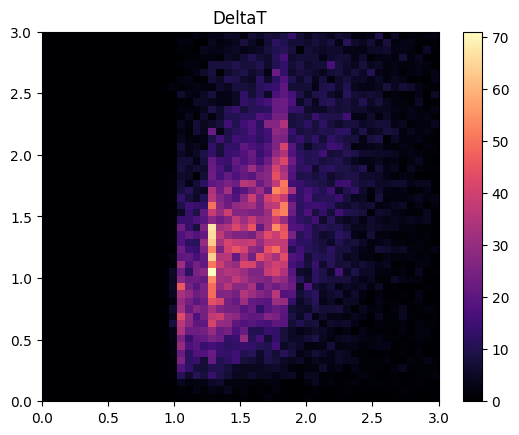

In [25]:
plt.figure(); plt.hist2d(np.ravel(result_deltaT_3.y_pred), np.ravel(result_deltaT_3.y_test), bins=(50, 50), cmap="magma", range = [(0.0, 3), (0.0, 3)]); plt.colorbar(); plt.title("DeltaT")